<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
LightGBM for Regression 
</p>

In [2]:
# Libraries for data manipulation and visualization
import numpy as np                               # For numerical operations
import pandas as pd                              # For data manipulation
import matplotlib.pyplot as plt                  # For plotting
import seaborn as sns                            # For advanced data visualization

# Libraries for model building and evaluation
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (                     # For model evaluation metrics
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error, 
    median_absolute_error
)

# LightGBM library
import lightgbm as lgb                            # For LightGBM Regressor

# ================================
# Set Seed for Reproducibility
# ================================
RANDOM_STATE = 50
np.random.seed(RANDOM_STATE)

# Suppress specific FutureWarning about 'force_all_finite'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite'.*")

In [3]:
# Define the path to the dataset
dataset_path = '../../all_data_files/cleaned_dataset_per_device.csv'

# Load the dataset
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"File not found at the specified path: {dataset_path}")
    import sys
    sys.exit()

# Display dataset information
print("\nDataset Information:")
df.info()

print("\nFirst Five Rows of the Dataset:")
display(df.head())

Dataset loaded successfully.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656317 entries, 0 to 656316
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         656317 non-null  object 
 1   device_id    656317 non-null  object 
 2   co2          656317 non-null  float64
 3   humidity     656317 non-null  float64
 4   pm25         656317 non-null  float64
 5   pressure     656317 non-null  float64
 6   temperature  656317 non-null  float64
 7   rssi         656317 non-null  float64
 8   snr          656317 non-null  float64
 9   SF           656317 non-null  int64  
 10  frequency    656317 non-null  float64
 11  f_count      656317 non-null  float64
 12  p_count      656317 non-null  float64
 13  toa          656317 non-null  float64
 14  distance     656317 non-null  int64  
 15  c_walls      656317 non-null  int64  
 16  w_walls      656317 non-null  int64  
 17  exp_pl       656

,time,device_id,co2,humidity,pm25,pressure,temperature,rssi,snr,SF,frequency,f_count,p_count,toa,distance,c_walls,w_walls,exp_pl,n_power,esp
0,2024-09-26 11:02:08.387851+00:00,ED0,539.0,49.34,0.39,299.69,24.57,-48.0,8.5,9,867.5,82.0,109.0,0.246784,10,0,0,65.4,-57.073822,-48.573822
1,2024-09-26 11:03:08.309590+00:00,ED0,540.0,49.33,0.80,299.77,24.59,-48.0,12.8,8,867.3,83.0,110.0,0.133632,10,0,0,65.4,-61.022142,-48.222142
2,2024-09-26 11:04:08.368448+00:00,ED0,537.0,49.28,0.71,299.70,24.62,-48.0,8.0,8,868.5,84.0,111.0,0.133632,10,0,0,65.4,-56.638920,-48.638920
3,2024-09-26 11:05:08.405529+00:00,ED0,537.0,49.34,0.56,299.69,24.63,-49.0,11.0,8,867.9,85.0,112.0,0.133632,10,0,0,66.4,-60.331956,-49.331956
4,2024-09-26 11:06:08.455112+00:00,ED0,534.0,49.28,0.60,299.73,24.64,-46.0,9.2,8,867.5,86.0,113.0,0.133632,10,0,0,63.4,-55.693058,-46.493058


In [4]:
# Define feature columns and target
feature_columns = [
    'distance', 'frequency', 'c_walls', 'w_walls', 
    'co2', 'humidity', 'pm25', 'pressure', 
    'temperature', 'snr'
]
target_column = 'exp_pl'

# Verify that all required columns exist
missing_columns = set(feature_columns + [target_column]) - set(df.columns)
if missing_columns:
    raise ValueError(f"The following required columns are missing in the dataset: {missing_columns}")

# Extract features and target
all_features = df[feature_columns].values
PL_all = df[target_column].values

# Perform train-test split (80-20 split)
X_train_all, X_test_all, PL_train_all, PL_test_all = train_test_split(
    all_features, PL_all, test_size=0.2, random_state=RANDOM_STATE
)

print("Train-test split completed.")

Train-test split completed.


In [5]:
# Define a single set of hyperparameters manually
hyperparameters = {
    'max_depth': 3,                              # Maximum depth of the tree
    'num_leaves': 7,                             # Set num_leaves to 2^max_depth - 1 for optimal performance
    'learning_rate': 0.05,                       # Step size shrinkage
    'n_estimators': 100,                         # Number of boosting iterations
    'subsample': 0.2,                            # Subsample ratio of the training instances
    'colsample_bytree': 0.2,                     # Subsample ratio of columns when constructing each tree
    'min_child_weight': 1,                       # Minimum sum of instance weight (hessian) needed in a child
    'reg_alpha': 0.5,                            # L1 regularization term on weights
    'reg_lambda': 0.5,                           # L2 regularization term on weights
    'objective': 'regression',                   # Regression task
    'verbosity': -1,                             # Suppress LightGBM warnings
    'random_state': 50,                          # Random seed
    'n_jobs': -1                                 # Use all available cores
}

print("\nTraining LightGBM model with hyperparameters.....\n")

# Initialize the LightGBM Regressor with the specified hyperparameters
lgb_model = lgb.LGBMRegressor(**hyperparameters)

# Train the model
lgb_model.fit(X_train_all, PL_train_all)

print("Model training completed....!\n")


Training LightGBM model with hyperparameters.....

Model training completed....!



In [6]:
# Initialize a list to store evaluation metrics for the model
evaluation_metrics = []

print("\nEvaluating the trained LightGBM model...")

# Make predictions on the training set
PL_train_pred = lgb_model.predict(X_train_all)
# Make predictions on the test set
PL_test_pred = lgb_model.predict(X_test_all)

# Calculate metrics
train_mse = mean_squared_error(PL_train_all, PL_train_pred)
test_mse = mean_squared_error(PL_test_all, PL_test_pred)
train_r2 = r2_score(PL_train_all, PL_train_pred)
test_r2 = r2_score(PL_test_all, PL_test_pred)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(PL_test_all, PL_test_pred)
test_median_ae = median_absolute_error(PL_test_all, PL_test_pred)

# Append metrics to the list
evaluation_metrics.append({
    'Model': 'LightGBM',
    'Training Loss (MSE)': train_mse,
    'Test Loss (MSE)': test_mse,
    'Test RMSE': test_rmse,
    'R² Score': test_r2,
    'Test MAPE (%)': test_mape * 100,
    'Test Median AE': test_median_ae
})

# Convert the metrics list to a DataFrame
evaluation_df = pd.DataFrame(evaluation_metrics)

print(f"\nModel Evaluation Metrics:")
# Display the transposed DataFrame
evaluation_df = evaluation_df.T[1:].reset_index(names=["Metric"]).rename(columns={0: "Value"})
display(evaluation_df)


Evaluating the trained LightGBM model...

Model Evaluation Metrics:


,Metric,Value
0,Training Loss (MSE),44.572164
1,Test Loss (MSE),44.449895
2,Test RMSE,6.667075
3,R² Score,0.877351
4,Test MAPE (%),5.197158
5,Test Median AE,3.445359


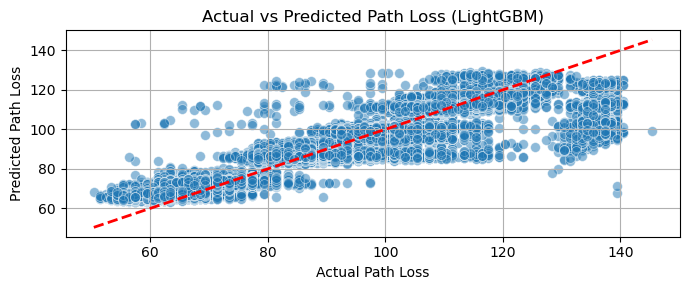

In [7]:
# Plot Actual vs Predicted Path Loss
plt.figure(figsize=(7, 3))
sns.scatterplot(x=PL_test_all, y=PL_test_pred, alpha=0.5, edgecolor='w', s=50)
plt.plot([PL_test_all.min(), PL_test_all.max()], [PL_test_all.min(), PL_test_all.max()], 'r--', lw=2)
plt.xlabel('Actual Path Loss')
plt.ylabel('Predicted Path Loss')
plt.title('Actual vs Predicted Path Loss (LightGBM)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Define the number of folds for cross-validation
n_folds = 5

# Initialize KFold with consistent RANDOM_STATE
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Initialize a list to store evaluation metrics for each fold
cv_results = []

print("\nPerforming K-Fold Cross-Validation...\n")

# Iterate over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_all), 1):

    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train_all[train_idx], X_train_all[val_idx]
    PL_train_fold, PL_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]

    # Initialize the LightGBM Regressor with the specified hyperparameters
    lgbm_cv = lgb.LGBMRegressor(**hyperparameters)

    # Train the model on the current fold
    lgbm_cv.fit(X_train_fold, PL_train_fold)

    # Make predictions on the validation set
    PL_val_pred = lgbm_cv.predict(X_val_fold)

    # Calculate evaluation metrics
    val_mse = mean_squared_error(PL_val_fold, PL_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(PL_val_fold, PL_val_pred)
    val_mape = mean_absolute_percentage_error(PL_val_fold, PL_val_pred)
    val_median_ae = median_absolute_error(PL_val_fold, PL_val_pred)

    # Append metrics to the cv_results list
    cv_results.append({
        'Fold': fold,
        'Validation Loss (MSE)': round(val_mse, 4),
        'Validation RMSE': round(val_rmse, 4),
        'R² Score': round(val_r2, 4),
        'Validation MAPE (%)': round(val_mape * 100, 2),
        'Validation Median AE': round(val_median_ae, 4)
    })

    # Print metrics for the current fold
    print(f" Fold {fold} - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, "
          f"MAPE: {val_mape*100:.2f}%, Median AE: {val_median_ae:.4f}\n")

# Convert the list of dictionaries to a DataFrame for better visualization
cv_results_df = pd.DataFrame(cv_results)

print("K-Fold Cross-Validation Results:")
display(cv_results_df)

# Summary statistics
cv_summary = cv_results_df.agg(['mean', 'std']).round(4).reset_index()
cv_summary.rename(columns={'index': 'Metric'}, inplace=True)

# Transposing the summary
cv_summary_transposed = cv_summary.set_index('Metric').T

print("\nCross-Validation Summary:")
display(cv_summary_transposed)


Performing K-Fold Cross-Validation...

 Fold 1 - MSE: 44.6623, RMSE: 6.6830, R²: 0.8767, MAPE: 5.20%, Median AE: 3.4434

 Fold 2 - MSE: 44.5242, RMSE: 6.6726, R²: 0.8771, MAPE: 5.20%, Median AE: 3.4260

 Fold 3 - MSE: 44.3151, RMSE: 6.6570, R²: 0.8780, MAPE: 5.21%, Median AE: 3.4644

 Fold 4 - MSE: 45.2812, RMSE: 6.7291, R²: 0.8756, MAPE: 5.21%, Median AE: 3.4559

 Fold 5 - MSE: 44.3018, RMSE: 6.6560, R²: 0.8774, MAPE: 5.19%, Median AE: 3.4287

K-Fold Cross-Validation Results:


,Fold,Validation Loss (MSE),Validation RMSE,R² Score,Validation MAPE (%),Validation Median AE
0,1,44.6623,6.6830,0.8767,5.20,3.4434
1,2,44.5242,6.6726,0.8771,5.20,3.4260
2,3,44.3151,6.6570,0.8780,5.21,3.4644
3,4,45.2812,6.7291,0.8756,5.21,3.4559
4,5,44.3018,6.6560,0.8774,5.19,3.4287



Cross-Validation Summary:


Metric,mean,std
Fold,3.0000,1.5811
Validation Loss (MSE),44.6169,0.4007
Validation RMSE,6.6795,0.0299
R² Score,0.8770,0.0009
Validation MAPE (%),5.2020,0.0084
Validation Median AE,3.4437,0.0167
